En lo que sigue, cuando hagamos referencias a teoremas o secciones, nos referimos a aquellos del libro Delaunay Mesh Generation de Chiu, et. al. Una versión en pdf esta adjunta en el correo.

Para calcular el diagrama de Voronoi, basta calcular la triangulación de Delaunay. Específicamente, para todo segmento AB en la triangulación de Delaunay checamos lo siguiente: Si AB pertenece a dos triángulos diferentes, dibujamos el segmento que conecta los circuncentros de estos triángulos. Si ABC es el único triangulo que contiene a AB, dibujamos el semirayo que empieza en el circuncirculo de ABC, es perpendicular a AB, y se extiende hacia el semiplano generado por AB que no contiene a C.

El converso también es cierto en el sentido de que para calcular la triangulación de Delaunay, basta calcular el diagrama de Voronoi. La demostración formal de esta dualidad se puede encontrar en el Teorema 7.1.

Para calcular la triangulación de Delaunay, usaremos el método de levantamiento. Específicamente, denotemos por $S$ a nuestro subconjunto finito de $\mathbb{R}^2$.

1.  Consideremos su levantamiento $S^+$ al paraboloide en $\mathbb{R}^3$, es decir, consideremos $S^+ = \{ (u, \| u \|^2) \in \mathbb{R}^3 : u \in S \}$.
2. Calculamos $\text{conv} S^+$, la envolvente convexa de $S^+$ (esto sera posible usando el método ConvexHull de scipy).
3. Identificamos las caras inferiores de $\text{conv} S^+$. Intuitivamente, estas son las caras de $\text{conv} S^+$ que seria visible desde el punto (0,0,-1). Formalmente, las caras inferiores de $\text{conv} S^+$ son aquellas cuyo vector normal tiene coordenada $Z$ negativa.
4. Proyectamos las caras inferiores de $\text{conv} S^+$ a $\mathbb{R}^2$. Esta proyección coincide con la triangulación de Delaunay de $S$.

Los detalles (y la demostración) de este método se pueden encontrar en la Sección 2.3.

Esto resume el algoritmo que implementaremos en el caso sin pesos. La idea general es la misma en el caso con pesos pero hay algunos detalles. El mas obvio es que no hemos definido una triangulación de Delaunay con pesos. Convenientemente, esta se define usando el método de levantamiento. Especificamente, denotemos por $S[\omega]$ a nuestro subconjunto finito de $\mathbb{R}^2$ con pesos $\omega$.

1. Consideremos su levantamiento $S[\omega]^+ = \{ (u, \| u \|^2 - \omega_u) \in \mathbb{R}^3 : u \in S[\omega] \}$.
2. Calculamos $\text{conv} S[\omega]^+$, la envolvente convexa de $S^+$ (esto sera posible usando el método ConvexHull de scipy).
3. Identificamos las caras inferiores de $\text{conv} S[\omega]^+$.
4. Proyectamos las caras inferiores de $\text{conv} S[\omega]^+$ a $\mathbb{R}^2$. Definimos la triangulación de Delaunay con pesos de $S$ como esta proyección.

La dualidad mencionada al inicio también se satisface en el caso con pesos. El único detalle es que falta generalizar el concepto de circuncentro. Por definición, el circuncentro $O$ de un triangulo $ABC$ es el (único) punto que satisface $d(O,A) = d(O,B) = d(O,C)$. La generalización es natural: El circuncentro $O$ del triangulo con peso $ABC$ es el único punto que satisface $\pi_A(O) = \pi_B(O) = \pi_C(O)$. Con esta definición se satisface la dualidad en el caso con pesos. La demostración formal se puede encontrar en el Teorema 7.2.

Esto concluye la idea general del algoritmo que implementaremos. El único detalle es que falta saber como calcular el circuncentro de un triangulo con peso. En nuestro caso, es decir, cuando los vertices son de la forma $(u, \| u \|^2 - \omega_u)$, basta conocer un vector normal $N = (N_0, N_1, N_2)$ al plano que contiene al triangulo con peso $ABC$. Veamos que
\begin{align}
	O = - \frac{1}{2N_2}(N_0, N_1)
\end{align}
es el circuncentro del triangulo con peso $ABC$.

Por definición de $N$,
\begin{align}
	A_0 N_0 + A_1 N_1 + (A_0^2 + A_1^2 - \omega_A)N_2 + C = 0.
\end{align}
para alguna constante $C$. Calculando directamente,
\begin{align}
	\pi_A \left( - \frac{1}{2N_2}(N_0, N_1) \right) & = \left\| (A_0, A_1) - \left( - \frac{1}{2N_2}(N_0, N_1) \right) \right\|^2 - \omega_A \\
	& = \left( A_0 + \frac{N_0}{2N_2} \right)^2 + \left( A_1 + \frac{N_1}{2N_2} \right)^2 - \omega_A \\
	& = A_0^2 + \frac{A_0N_0}{N_2} + \frac{N_0^2}{4N_2^2} + A_1^2 + \frac{A_1N_1}{N_2} + \frac{N_1^2}{4N_2^2} - \omega_A \\
  & = \frac{N_0^2}{4N_2^2} + \frac{N_1^2}{4N_2^2} - \frac{C}{N_2}
\end{align}
donde la última igualdad es consecuencia de la ecuación anterior. Como la última expresión no depende de $A$, obtenemos lo deseado.

Con todo esto en mente, procedemos a la implementación.

In [1]:
import itertools

import numpy as np
from scipy.spatial import ConvexHull, Voronoi, voronoi_plot_2d

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon as MplPolygon

from shapely.geometry import Point, LineString, Polygon
from shapely.ops import unary_union

In [2]:
def norm2(X):
  return np.sqrt(np.sum(X**2))

In [3]:
def normalized(X):
  return X / norm2(X)

In [4]:
def ccenter(A,B,C):
  N = np.cross(B-A,C-A)
  return -(1 / (2 * N[2])) * N[:2]

In [5]:
def ccw(A,B,C):
  ABC_mtx = np.stack([A,B,C])
  col_ones = np.ones((3,1))
  M = np.concatenate([ABC_mtx, col_ones], axis=1)
  return np.linalg.det(M) > 0

In [6]:
def wDel(S,w):

  S_norm = np.sum(S**2, axis=1) - w**2
  Sw_lift = np.concatenate([S, S_norm[:,None]], axis=1)

  conv_Sw = ConvexHull(Sw_lift)

  lower_faces = []
  for simplex, eq in zip(conv_Sw.simplices, conv_Sw.equations):
    if eq[2] <= 0:
      i,j,k = simplex
      if ccw(S[i],S[j],S[k]):
        lower_faces.append([i,j,k])
      else:
        lower_faces.append([i,k,j])

  ccenters = np.array([ccenter(*Sw_lift[tri]) for tri in lower_faces])

  return lower_faces, ccenters

In [7]:
def wVor(S,w):

  lower_faces, ccenters = wDel(S,w)

  which_tri = {}
  for n, tri in enumerate(lower_faces):
    for edge in itertools.combinations(tri, 2):
      edge = tuple(sorted(edge))
      which_tri.setdefault(edge, []).append(n)

  vor = {}
  for n, (i,j,k) in enumerate(lower_faces):
    for r,s,t in [(i,j,k), (j,k,i), (k,i,j)]:
      edge = tuple(sorted((r,s)))
      if len(which_tri[edge]) == 2:
        m = (set(which_tri[edge]) - {n}).pop()
        dir = ccenters[m] - ccenters[n]
        segment = (ccenters[n], normalized(dir), 0, norm2(dir))
        vor.setdefault(r, []).append(((n,m), segment))
      else:
        P, Q, R, C = S[r], S[s], S[t], ccenters[n]
        I = P + np.dot(C-P, normalized(Q-P)) * normalized(Q-P)
        dir = I - C
        if np.dot(I-C, I-R) < 0:
          dir = -dir
        P_segment = (C, normalized(dir), 0, None)
        Q_segment = (C, -normalized(dir), None, 0)
        vor.setdefault(r, []).append(((n,-1), P_segment))
        vor.setdefault(s, []).append(((-1,n), Q_segment))

  def order_segments(segments):
    start = min((seg[0][0], i) for i, seg in enumerate(segments))[1]
    segments[0], segments[start] = segments[start], segments[0]
    for i in range(len(segments)-1):
      for j in range(i+1, len(segments)):
        if segments[i][0][1] == segments[j][0][0]:
          segments[i+1], segments[j] = segments[j], segments[i+1]
          break
    return segments

  return {i: order_segments(segments) for i, segments in vor.items()}

In [8]:
def draw_wVor(S,w):

  lower_faces, ccenters = wDel(S,w)
  vor = wVor(S,w)

  fig, ax = plt.subplots()
  plt.axis('equal')

  min_corner = np.amin(S, axis=0) - np.max(w)
  max_corner = np.amax(S, axis=0) + np.max(w)
  ax.set_aspect('equal', adjustable='box')
  ax.set_xlim(min_corner[0], max_corner[0])
  ax.set_ylim(min_corner[1], max_corner[1])

  for Si, wi in zip(S, w):
    circle = plt.Circle(
        Si,
        wi,
        fill=True,
        alpha=0.4,
        lw=0,
        color="#8080f0",
        zorder=1
    )
    ax.add_artist(circle)

  edge_set = frozenset(
    tuple(sorted(edge))
    for tri in lower_faces
    for edge in itertools.combinations(tri, 2)
    )

  edges = [(S[i], S[j]) for i, j in edge_set]
  line_list = LineCollection(edges, lw=1.0, colors=".9")
  line_list.set_zorder(0)
  ax.add_collection(line_list)

  edge_map = {}
  for segments in vor.values():
    for edge, (A, U, tmin, tmax) in segments:
        edge = tuple(sorted(edge))
        t0 = -10 if tmin is None else tmin
        t1 = 10 if tmax is None else tmax
        edge_map.setdefault(edge, (A + t0 * U, A + t1 * U))

  line_list = LineCollection(edge_map.values(), lw = 1., colors = 'k')
  line_list.set_zorder(0)
  ax.add_collection(line_list)

  plt.show()

In [9]:
def clip_cell_with_circle(cell_segments, center, r):
    points = []
    for (_, (A, U, tmin, tmax)) in cell_segments:
        if tmin is None:
            tmin = -10
        if tmax is None:
            tmax = 10
        p1 = tuple((A + tmin * U).round(8))
        p2 = tuple((A + tmax * U).round(8))
        points.append(p1)
        points.append(p2)

    seen = set()
    unique_points = []
    for p in points:
        if p not in seen:
            unique_points.append(p)
            seen.add(p)

    if len(unique_points) < 3:
        return Point(center).buffer(0)

    try:
        cell_poly = Polygon(unique_points)
        if not cell_poly.is_valid:
            cell_poly = cell_poly.buffer(0)

        circle = Point(center).buffer(r, resolution=64)
        result = cell_poly.intersection(circle)

        if not result.is_valid:
            result = result.buffer(0)

        return result

    except Exception as e:
        print(f"Error while clipping cell at {center}: {e}")
        return Point(center).buffer(0)

In [10]:
def draw_wAlpha(S, w, r):
    lower_faces, ccenters = wDel(S, w)
    vor = wVor(S, w)

    fig, ax = plt.subplots()
    plt.axis('equal')

    min_corner = np.amin(S, axis=0) - r
    max_corner = np.amax(S, axis=0) + r
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(min_corner[0], max_corner[0])
    ax.set_ylim(min_corner[1], max_corner[1])

    clipped_lines = []

    for i, cell in vor.items():
        center = S[i]
        circle = Point(center).buffer(r, resolution=64)

        for (_, (A, U, tmin, tmax)) in cell:
            t0 = -10 if tmin is None else tmin
            t1 = 10 if tmax is None else tmax
            p1 = A + t0 * U
            p2 = A + t1 * U
            segment = LineString([p1, p2])
            clipped = segment.intersection(circle)

            if not clipped.is_empty:
                if isinstance(clipped, LineString):
                    clipped_lines.append(clipped)
                elif hasattr(clipped, 'geoms'):
                    for g in clipped.geoms:
                        if isinstance(g, LineString):
                            clipped_lines.append(g)

    if clipped_lines:
        line_segments = [
            list(line.coords) for line in clipped_lines
        ]
        edge_lines = LineCollection(
            line_segments, colors='black',
            linewidths=1.5, zorder=1
        )
        ax.add_collection(edge_lines)

    for i, cell in vor.items():
        clipped_region = clip_cell_with_circle(cell, S[i], r)

        if not clipped_region.is_empty:
            if isinstance(clipped_region, Polygon):
                p = MplPolygon(
                    list(clipped_region.exterior.coords),
                    closed=True, alpha=0.6,
                    color="#90d0f0", lw=0
                )
                ax.add_patch(p)
            elif hasattr(clipped_region, 'geoms'):
                for geom in clipped_region.geoms:
                    if isinstance(geom, Polygon):
                        p = MplPolygon(
                            list(geom.exterior.coords),
                            closed=True, alpha=0.6,
                            color="#90d0f0", lw=0
                        )
                        ax.add_patch(p)

    ax.scatter(S[:, 0], S[:, 1], c='black', s=10, zorder=2)

    plt.show()

In [11]:
N = 10
S = np.random.default_rng().random((N, 2))
w = 0.1 * np.random.random(N)

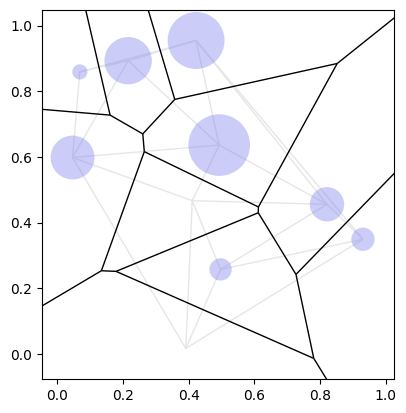

In [12]:
draw_wVor(S,w)

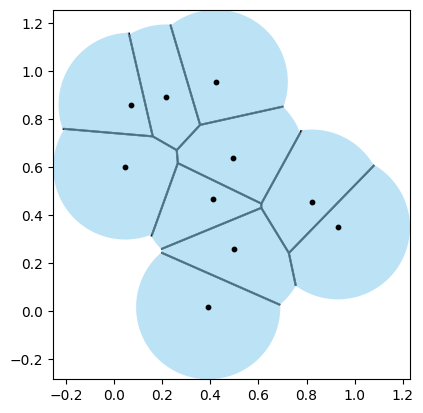

In [13]:
r = 0.3
draw_wAlpha(S,w,r)

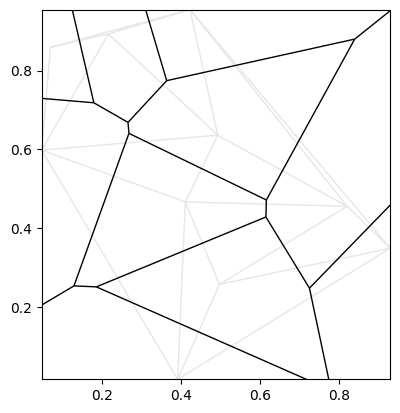

In [14]:
draw_wVor(S,0*w)

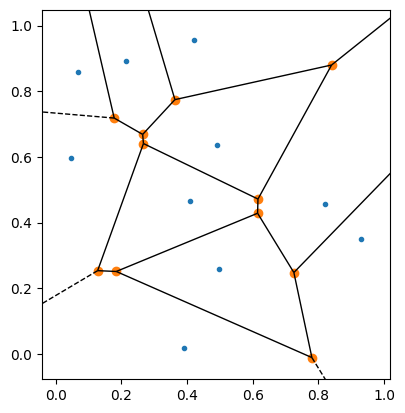

In [15]:
vor = Voronoi(S)
fig = voronoi_plot_2d(vor)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()